# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, \
                                    GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, accuracy_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
!pip install optuna

import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
train_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_values.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/test_values.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/SubmissionFormat.csv')

Mounted at /content/drive


In [4]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Preprocessing Summary:

- Change `region_code` & `district_code` to 'object' type
- Change `construction_year` to 'object' type
- Convert `date_recorded` into year, month, & day features
- Dropped `num_private`, `recorded_by`, & `date_recorded` features

#### Encoding
- Fill missing values in categorical columns with 'unknown'
- Replaced instances from `funder`, `installer`, and `wpt_name` to 'Other' if less than 50
- OneHotEncoded categorical features (threshold: 150 or less)
- LabelEncoded remaining categorical features (likely none)

In [5]:
# Convert 'region_code' and 'district_code' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')

# Try 'construction_year' as type 'object'
train_df['construction_year'] = train_df['construction_year'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Drop columns 'num_private', 'recorded_by', 'date_recorded' (and 'id' from train_df)
train_df = train_df.drop(columns=['num_private',
                                  'recorded_by',
                                  'date_recorded',
                                  'id'])
test_features = test_features.drop(columns=['num_private',
                                            'recorded_by',
                                            'date_recorded',
                                            'id'])

In [6]:
# Fill Categorical Columns with missing values with 'unknown'
categorical_columns = test_features.select_dtypes(include=['object']).columns

train_df[categorical_columns] = train_df[categorical_columns].fillna('unknown')
test_features[categorical_columns] = test_features[categorical_columns].fillna('unknown')

# Categorical Columns to lower case
train_df[categorical_columns] = train_df[categorical_columns].map(
    lambda x: x.lower() if isinstance(x, str) else x)
test_features[categorical_columns] = train_df[categorical_columns].map(
    lambda x: x.lower() if isinstance(x, str) else x)

In [7]:
# Split `train_df` into train and test sets before additional encoding to prevent data leakage
X = train_df.drop(columns='status_group', axis=1)
y = train_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=604)

In [8]:
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name' if less than 200
# 200 appears to be the best threshold based on RF (vs. 100 or 300)

# Define the columns to be transformed
columns_to_transform = ['funder', 'installer', 'wpt_name',
                        'subvillage', 'scheme_name', 'ward'] # Try reducing features

# Function to replace infrequent categories with 'other'
def replace_infrequent_categories(df, columns, threshold=200):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'other')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

In [9]:
# Threshold for OneHotEncoding
threshold = 150

# Identify categorical features and their unique value counts
categorical_features = X_train.select_dtypes(include=['object']).columns
category_counts = X_train[categorical_features].nunique()

# Separate features based on the threshold
onehot_features = category_counts[category_counts < threshold].index.tolist()
labelencode_features = category_counts[category_counts >= threshold].index.tolist()

In [10]:
# Convert boolean features to strings
X_train[onehot_features] = X_train[onehot_features].astype(str)
X_test[onehot_features] = X_test[onehot_features].astype(str)

# Apply OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[onehot_features])
X_test_ohe = ohe.transform(X_test[onehot_features])

# Do the same for test_features
test_features[onehot_features] = test_features[onehot_features].astype(str)
test_features_ohe = ohe.transform(test_features[onehot_features])

In [11]:
# Apply Label Encoding (if needed)
label_encoders = {}
for col in labelencode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))  # Convert to string
    # Use fit_transform on X_test to handle unseen labels
    X_test[col] = X_test[col].astype(str).map(lambda s: 'unknown' if s not in le.classes_ else s)  # Convert to string
    le.classes_ = np.append(le.classes_, 'unknown')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Combine OneHotEncoded and LabelEncoded features with numeric features
X_train_encoded = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(onehot_features))
X_test_encoded = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_train_final = pd.concat([
    X_train_encoded.reset_index(drop=True),
    X_train[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)
], axis=1)

X_test_final = pd.concat([
    X_test_encoded.reset_index(drop=True),
    X_test[labelencode_features + X.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)
], axis=1)

print(f"Number of features after encoding: {X_train_final.shape[1]}")

Number of features after encoding: 398


In [12]:
# Label Encode for test_features
for col in labelencode_features:
    if col in test_features.columns:
        le = label_encoders[col]
        test_features[col] = test_features[col].map(
            lambda s: 'unknown' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, 'unknown')
        test_features[col] = le.transform(test_features[col])

test_features_encoded = pd.DataFrame(test_features_ohe, columns=ohe.get_feature_names_out(onehot_features))

test_features_final = pd.concat([test_features_encoded.reset_index(drop=True),
                                 test_features[labelencode_features + X.select_dtypes(
                                     include=['number']).columns.tolist()].reset_index(drop=True)], axis=1)

## CatBoost will have separate notebook
- Documentation states not to use OneHotEncoding with CatBoost as it will affect the model
- Use internal OHE option instead
- Will use separate notebook

# Random Forest Classifier

In [13]:
# Define the objective function for Random Forest
def rf_objective(trial):
    rf_param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 75),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_float('max_features', 0.7, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    model = RandomForestClassifier(**rf_param_grid, random_state=42)
    score = cross_val_score(
        model, X_train_final, y_train, cv=3, scoring='accuracy').mean()
    return score

# Create a study and optimize
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=30)

[I 2024-08-09 06:12:05,760] A new study created in memory with name: no-name-7827f14f-e70b-465e-9b90-ba0e607a3cc9
[I 2024-08-09 06:22:44,090] Trial 0 finished with value: 0.8002886002886003 and parameters: {'n_estimators': 194, 'max_depth': 69, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.8103538204608343, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.8002886002886003.
[I 2024-08-09 06:32:38,360] Trial 1 finished with value: 0.786075036075036 and parameters: {'n_estimators': 144, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.8581591711881469, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8002886002886003.
[I 2024-08-09 06:37:25,432] Trial 2 finished with value: 0.802934102934103 and parameters: {'n_estimators': 102, 'max_depth': 66, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.9712427525552044, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with

In [14]:
# Best parameters for Random Forest
rf_best_params = rf_study.best_params
print("Best RF parameters: ", rf_best_params)

Best RF parameters:  {'n_estimators': 102, 'max_depth': 66, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.9712427525552044, 'bootstrap': True, 'criterion': 'entropy'}


**Best RF parameters:**  {'n_estimators': 102, 'max_depth': 66, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.9712427525552044, 'bootstrap': True, 'criterion': 'entropy'}

In [15]:
# Train the final model on the entire training data using the best hyperparameters
rf_model = RandomForestClassifier(**rf_best_params)
rf_model.fit(X_train_final, y_train)

RandomForestClassifier(criterion='entropy', max_depth=66,
                       max_features=0.9712427525552044, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=102)

In [16]:
rf_preds = rf_model.predict(X_test_final)

print(f"Accuracy: {accuracy_score(y_test, rf_preds)}")
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

Accuracy: 0.8061167227833894
Random Forest Classification Report:
                          precision    recall  f1-score   support

             functional       0.80      0.90      0.85      9678
functional needs repair       0.59      0.32      0.41      1295
         non functional       0.84      0.77      0.80      6847

               accuracy                           0.81     17820
              macro avg       0.74      0.66      0.69     17820
           weighted avg       0.80      0.81      0.80     17820



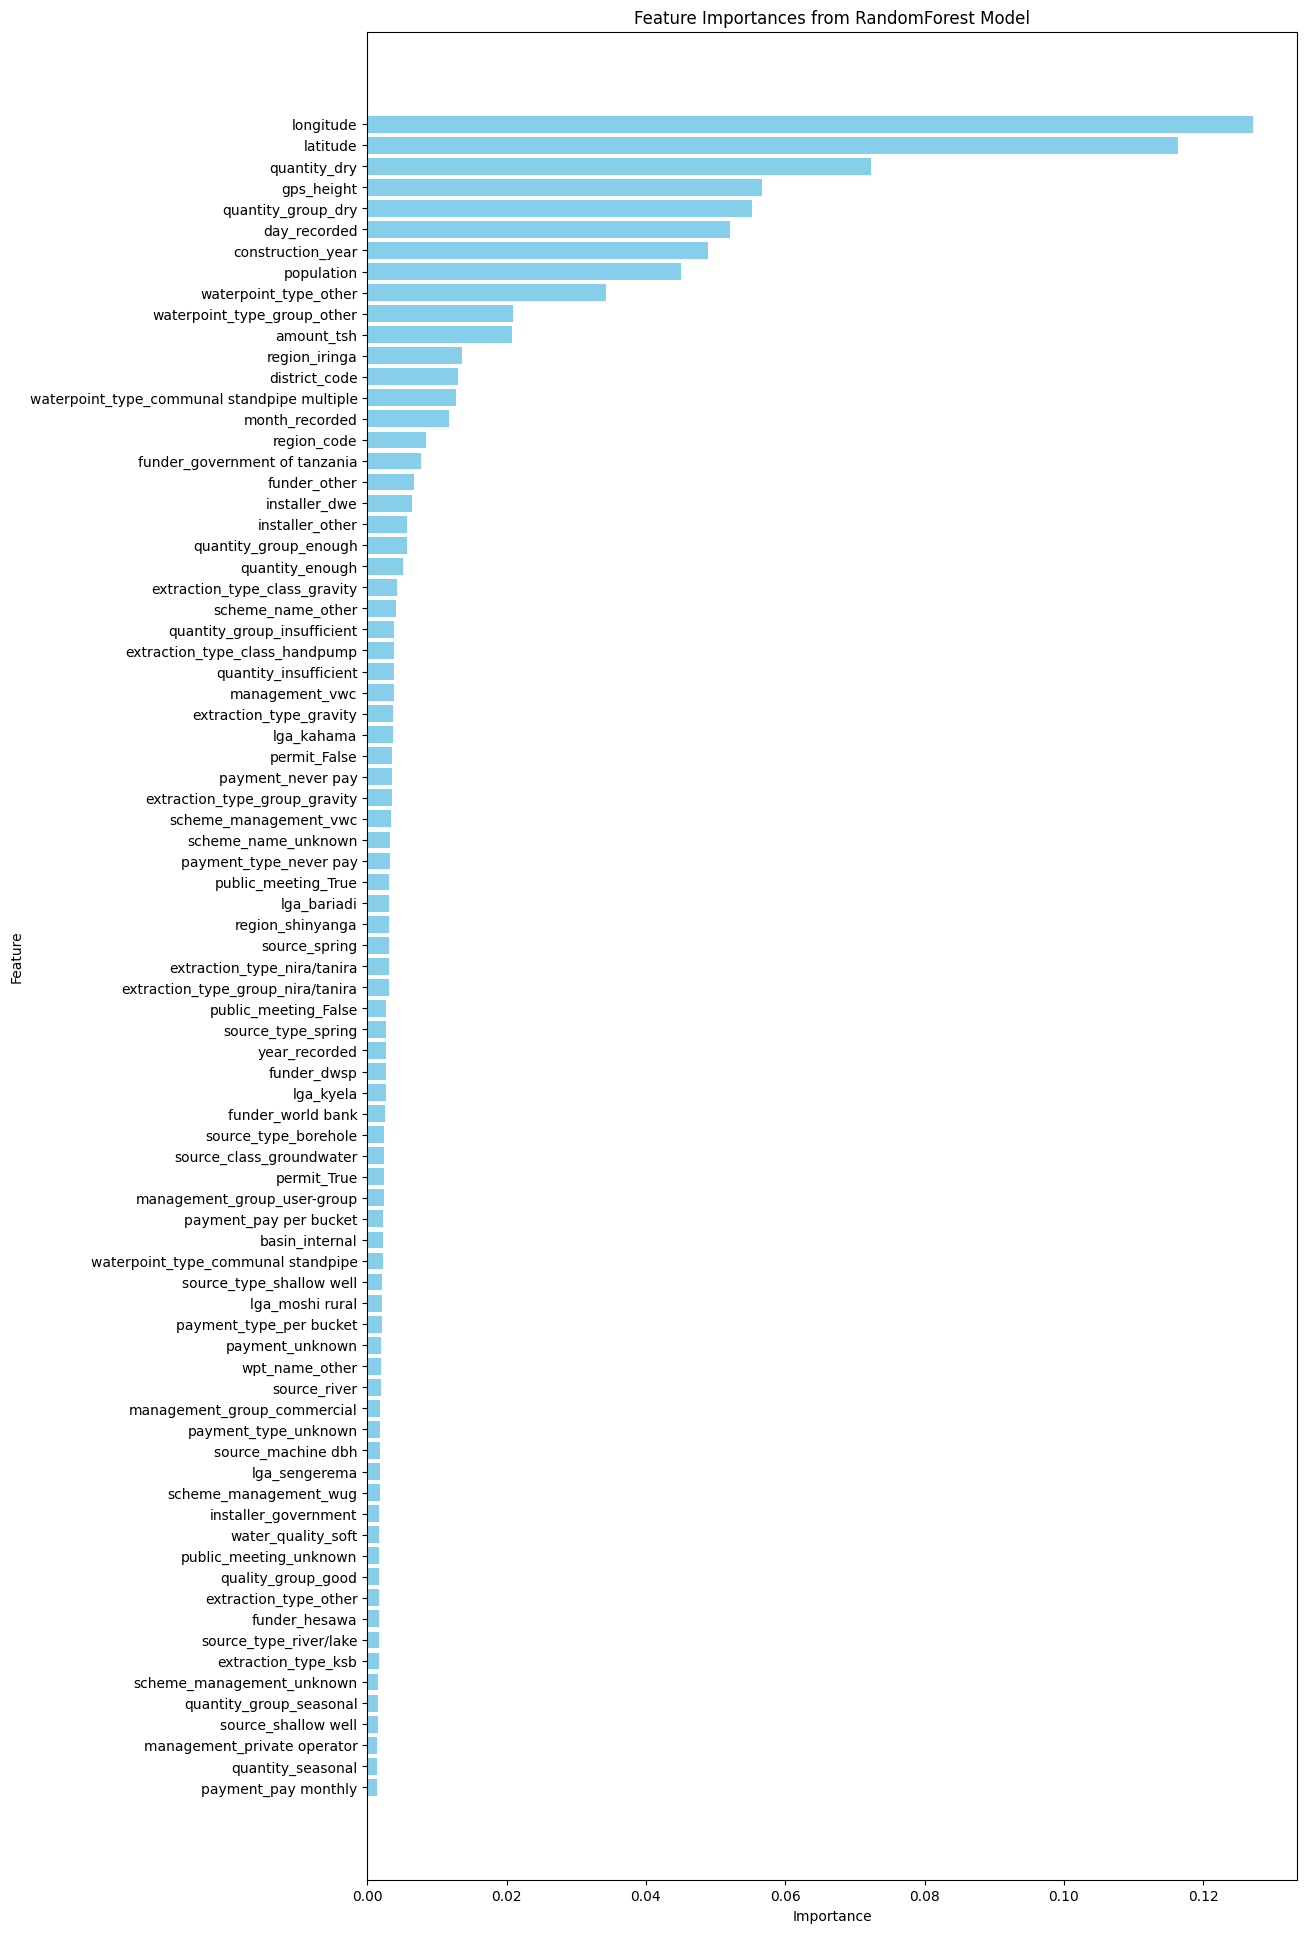

In [17]:
# Get feature importances from the best RandomForest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': rf_feature_importances
})

# Sort the DataFrame by importance
rf_features_df = rf_features_df.sort_values(by='Importance', ascending=False).head(80)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(rf_features_df['Feature'], rf_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

In [18]:
# Predict using RandomForest model
rf_test_preds = rf_model.predict(test_features_final)

# Replace values in 'status_group' with rf_test_preds
submission['status_group'] = rf_test_preds

submission.to_csv('submission_rf8.csv', index=False)

# LGBM

In [19]:
# Define the objective function for LightGBM
def lgbm_objective(trial):
    lgbm_param_grid = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 70),
        'max_depth': trial.suggest_int('max_depth', 10, 75),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.5)
    }

    model = lgb.LGBMClassifier(**lgbm_param_grid)
    score = cross_val_score(model, X_train_final, y_train, cv=3, scoring='accuracy').mean()
    return score

# Create a study and optimize
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=20)

[I 2024-08-09 11:05:36,035] A new study created in memory with name: no-name-33df755f-3b84-4b96-bb1d-88e910f0d8e4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 390
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:06:22,494] Trial 0 finished with value: 0.801034151034151 and parameters: {'num_leaves': 46, 'max_depth': 25, 'learning_rate': 0.05310738511083237, 'n_estimators': 560, 'min_child_samples': 23, 'subsample': 0.9143708319505215, 'colsample_bytree': 0.8841759826848135, 'reg_alpha': 0.38088140275185034, 'reg_lambda': 0.15167261907982055}. Best is trial 0 with value: 0.801034151034151.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 390
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1991
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:07:35,370] Trial 1 finished with value: 0.7955507455507456 and parameters: {'num_leaves': 36, 'max_depth': 53, 'learning_rate': 0.018644573292532246, 'n_estimators': 922, 'min_child_samples': 24, 'subsample': 0.9305966162119403, 'colsample_bytree': 0.7215922598205142, 'reg_alpha': 0.32393316071027156, 'reg_lambda': 0.45734395445336556}. Best is trial 0 with value: 0.801034151034151.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 390
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:08:27,245] Trial 2 finished with value: 0.7836219336219337 and parameters: {'num_leaves': 41, 'max_depth': 74, 'learning_rate': 0.011185902544561673, 'n_estimators': 514, 'min_child_samples': 22, 'subsample': 0.9951611235700648, 'colsample_bytree': 0.7352497486371932, 'reg_alpha': 0.47049273214850185, 'reg_lambda': 0.05195252363523928}. Best is trial 0 with value: 0.801034151034151.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1973
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 384
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-08-09 11:09:55,822] Trial 3 finished with value: 0.8011544011544012 and parameters: {'num_leaves': 68, 'max_depth': 17, 'learning_rate': 0.025058542889526917, 'n_estimators': 853, 'min_child_samples': 37, 'subsample': 0.8703481811811399, 'colsample_bytree': 0.8235966500547282, 'reg_alpha': 0.007760261064781171, 'reg_lambda': 0.16301374484725478}. Best is trial 3 with value: 0.8011544011544012.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 390
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:11:17,593] Trial 4 finished with value: 0.7928090428090427 and parameters: {'num_leaves': 57, 'max_depth': 66, 'learning_rate': 0.010348037454617869, 'n_estimators': 758, 'min_child_samples': 22, 'subsample': 0.6139204023340827, 'colsample_bytree': 0.9837905589338994, 'reg_alpha': 0.31193595946519337, 'reg_lambda': 0.3141371456161812}. Best is trial 3 with value: 0.8011544011544012.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 382
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1973
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:12:07,196] Trial 5 finished with value: 0.8010582010582011 and parameters: {'num_leaves': 41, 'max_depth': 49, 'learning_rate': 0.04876037404409194, 'n_estimators': 635, 'min_child_samples': 42, 'subsample': 0.8563602015501071, 'colsample_bytree': 0.7269349378801883, 'reg_alpha': 0.34190642955313855, 'reg_lambda': 0.035276003162963865}. Best is trial 3 with value: 0.8011544011544012.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 390
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-08-09 11:12:58,584] Trial 6 finished with value: 0.8017556517556517 and parameters: {'num_leaves': 51, 'max_depth': 21, 'learning_rate': 0.0483113061095357, 'n_estimators': 624, 'min_child_samples': 21, 'subsample': 0.607921921225833, 'colsample_bytree': 0.6518508980573686, 'reg_alpha': 0.1652442804635399, 'reg_lambda': 0.1039226810816416}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 377
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1961
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:13:49,255] Trial 7 finished with value: 0.7871332371332372 and parameters: {'num_leaves': 40, 'max_depth': 68, 'learning_rate': 0.01572457079319918, 'n_estimators': 519, 'min_child_samples': 48, 'subsample': 0.9379500025612751, 'colsample_bytree': 0.8873434913752116, 'reg_alpha': 0.49618407500315664, 'reg_lambda': 0.3455264065496173}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 390
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-08-09 11:14:57,704] Trial 8 finished with value: 0.7971139971139971 and parameters: {'num_leaves': 70, 'max_depth': 22, 'learning_rate': 0.017039390308350427, 'n_estimators': 562, 'min_child_samples': 23, 'subsample': 0.8621591078320605, 'colsample_bytree': 0.7440882795741554, 'reg_alpha': 0.09055941595349637, 'reg_lambda': 0.15246778648973208}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 377
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:16:16,215] Trial 9 finished with value: 0.7983405483405482 and parameters: {'num_leaves': 52, 'max_depth': 53, 'learning_rate': 0.0212068074436783, 'n_estimators': 775, 'min_child_samples': 50, 'subsample': 0.7684821936547863, 'colsample_bytree': 0.668367228650303, 'reg_alpha': 0.27597394443199685, 'reg_lambda': 0.3942575587155979}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 387
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:17:15,495] Trial 10 finished with value: 0.8004088504088505 and parameters: {'num_leaves': 59, 'max_depth': 33, 'learning_rate': 0.09584886168955833, 'n_estimators': 676, 'min_child_samples': 30, 'subsample': 0.6051855857033542, 'colsample_bytree': 0.6022950583731506, 'reg_alpha': 0.17298639966835383, 'reg_lambda': 0.2490864853203554}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 385
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-08-09 11:18:49,454] Trial 11 finished with value: 0.8007215007215006 and parameters: {'num_leaves': 69, 'max_depth': 11, 'learning_rate': 0.03423157250544795, 'n_estimators': 908, 'min_child_samples': 36, 'subsample': 0.7199137876468273, 'colsample_bytree': 0.8143303844360558, 'reg_alpha': 0.001656616137522826, 'reg_lambda': 0.1545429856863447}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 387
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[I 2024-08-09 11:20:11,146] Trial 12 finished with value: 0.8013708513708514 and parameters: {'num_leaves': 62, 'max_depth': 16, 'learning_rate': 0.0325316679762726, 'n_estimators': 830, 'min_child_samples': 34, 'subsample': 0.6950081405149531, 'colsample_bytree': 0.8318796055347956, 'reg_alpha': 0.1865709611742124, 'reg_lambda': 0.22558757329546994}. Best is trial 6 with value: 0.8017556517556517.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 387
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 389
[LightGBM] [Info] Start training f

[I 2024-08-09 11:21:19,090] Trial 13 finished with value: 0.8029100529100529 and parameters: {'num_leaves': 61, 'max_depth': 36, 'learning_rate': 0.04573010501904497, 'n_estimators': 676, 'min_child_samples': 30, 'subsample': 0.6788522462537612, 'colsample_bytree': 0.606955868679369, 'reg_alpha': 0.1980782666556129, 'reg_lambda': 0.235463612246551}. Best is trial 13 with value: 0.8029100529100529.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 388
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:22:13,282] Trial 14 finished with value: 0.803102453102453 and parameters: {'num_leaves': 51, 'max_depth': 36, 'learning_rate': 0.06361003026173281, 'n_estimators': 676, 'min_child_samples': 29, 'subsample': 0.6662341089646149, 'colsample_bytree': 0.6035479251640612, 'reg_alpha': 0.19291395597780317, 'reg_lambda': 0.0877721772930703}. Best is trial 14 with value: 0.803102453102453.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 389
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:23:13,963] Trial 15 finished with value: 0.8017075517075517 and parameters: {'num_leaves': 63, 'max_depth': 38, 'learning_rate': 0.08151650295410155, 'n_estimators': 687, 'min_child_samples': 28, 'subsample': 0.6737886258230414, 'colsample_bytree': 0.6524826144205813, 'reg_alpha': 0.23371125361808814, 'reg_lambda': 0.009101419746539108}. Best is trial 14 with value: 0.803102453102453.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 387
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:24:35,648] Trial 16 finished with value: 0.8013708513708514 and parameters: {'num_leaves': 54, 'max_depth': 32, 'learning_rate': 0.06482400161477854, 'n_estimators': 995, 'min_child_samples': 30, 'subsample': 0.7529593097223389, 'colsample_bytree': 0.6070812799817146, 'reg_alpha': 0.10086794985101094, 'reg_lambda': 0.30300873550890484}. Best is trial 14 with value: 0.803102453102453.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 389
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:25:33,459] Trial 17 finished with value: 0.801010101010101 and parameters: {'num_leaves': 46, 'max_depth': 39, 'learning_rate': 0.03947279802147685, 'n_estimators': 708, 'min_child_samples': 27, 'subsample': 0.6672294114489011, 'colsample_bytree': 0.6843740618396206, 'reg_alpha': 0.09526220564326521, 'reg_lambda': 0.4978656208476628}. Best is trial 14 with value: 0.803102453102453.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 387
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:26:22,501] Trial 18 finished with value: 0.8016835016835017 and parameters: {'num_leaves': 46, 'max_depth': 46, 'learning_rate': 0.06734895207894179, 'n_estimators': 618, 'min_child_samples': 33, 'subsample': 0.8016531644822048, 'colsample_bytree': 0.600058535093334, 'reg_alpha': 0.22716687128534158, 'reg_lambda': 0.21342191709103409}. Best is trial 14 with value: 0.803102453102453.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 27720, number of used features: 382
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.622031
[LightGBM] [Info] Start training from score -0.956407
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1977
[LightGBM] [Info] Number of data points in the train set: 27720,

[I 2024-08-09 11:27:36,387] Trial 19 finished with value: 0.8010101010101011 and parameters: {'num_leaves': 64, 'max_depth': 28, 'learning_rate': 0.0660465632179755, 'n_estimators': 799, 'min_child_samples': 41, 'subsample': 0.8049901154935684, 'colsample_bytree': 0.7716998244586403, 'reg_alpha': 0.1446898549111563, 'reg_lambda': 0.08640823202166516}. Best is trial 14 with value: 0.803102453102453.


In [20]:
# Best parameters for LightGBM
lgbm_best_params = lgbm_study.best_params
print("Best LGBM parameters: ", lgbm_best_params)

Best LGBM parameters:  {'num_leaves': 51, 'max_depth': 36, 'learning_rate': 0.06361003026173281, 'n_estimators': 676, 'min_child_samples': 29, 'subsample': 0.6662341089646149, 'colsample_bytree': 0.6035479251640612, 'reg_alpha': 0.19291395597780317, 'reg_lambda': 0.0877721772930703}


**Best LGBM parameters:** {'num_leaves': 51, 'max_depth': 36, 'learning_rate': 0.06361003026173281, 'n_estimators': 676, 'min_child_samples': 29, 'subsample': 0.6662341089646149, 'colsample_bytree': 0.6035479251640612, 'reg_alpha': 0.19291395597780317, 'reg_lambda': 0.0877721772930703}

In [21]:
# Train the final model on the entire training data using the best hyperparameters
lgbm_model = lgb.LGBMClassifier(**lgbm_best_params)
lgbm_model.fit(X_train_final, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 41580, number of used features: 391
[LightGBM] [Info] Start training from score -0.610510
[LightGBM] [Info] Start training from score -2.621700
[LightGBM] [Info] Start training from score -0.956469


LGBMClassifier(colsample_bytree=0.6035479251640612,
               learning_rate=0.06361003026173281, max_depth=36,
               min_child_samples=29, n_estimators=676, num_leaves=51,
               reg_alpha=0.19291395597780317, reg_lambda=0.0877721772930703,
               subsample=0.6662341089646149)

In [22]:
lgbm_preds = lgbm_model.predict(X_test_final)
print(f"Accuracy: {accuracy_score(y_test, lgbm_preds)}")
print("LightGBM Classification Report:\n", classification_report(y_test, lgbm_preds))

Accuracy: 0.804601571268238
LightGBM Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9678
functional needs repair       0.62      0.28      0.39      1295
         non functional       0.84      0.76      0.80      6847

               accuracy                           0.80     17820
              macro avg       0.75      0.65      0.68     17820
           weighted avg       0.80      0.80      0.79     17820



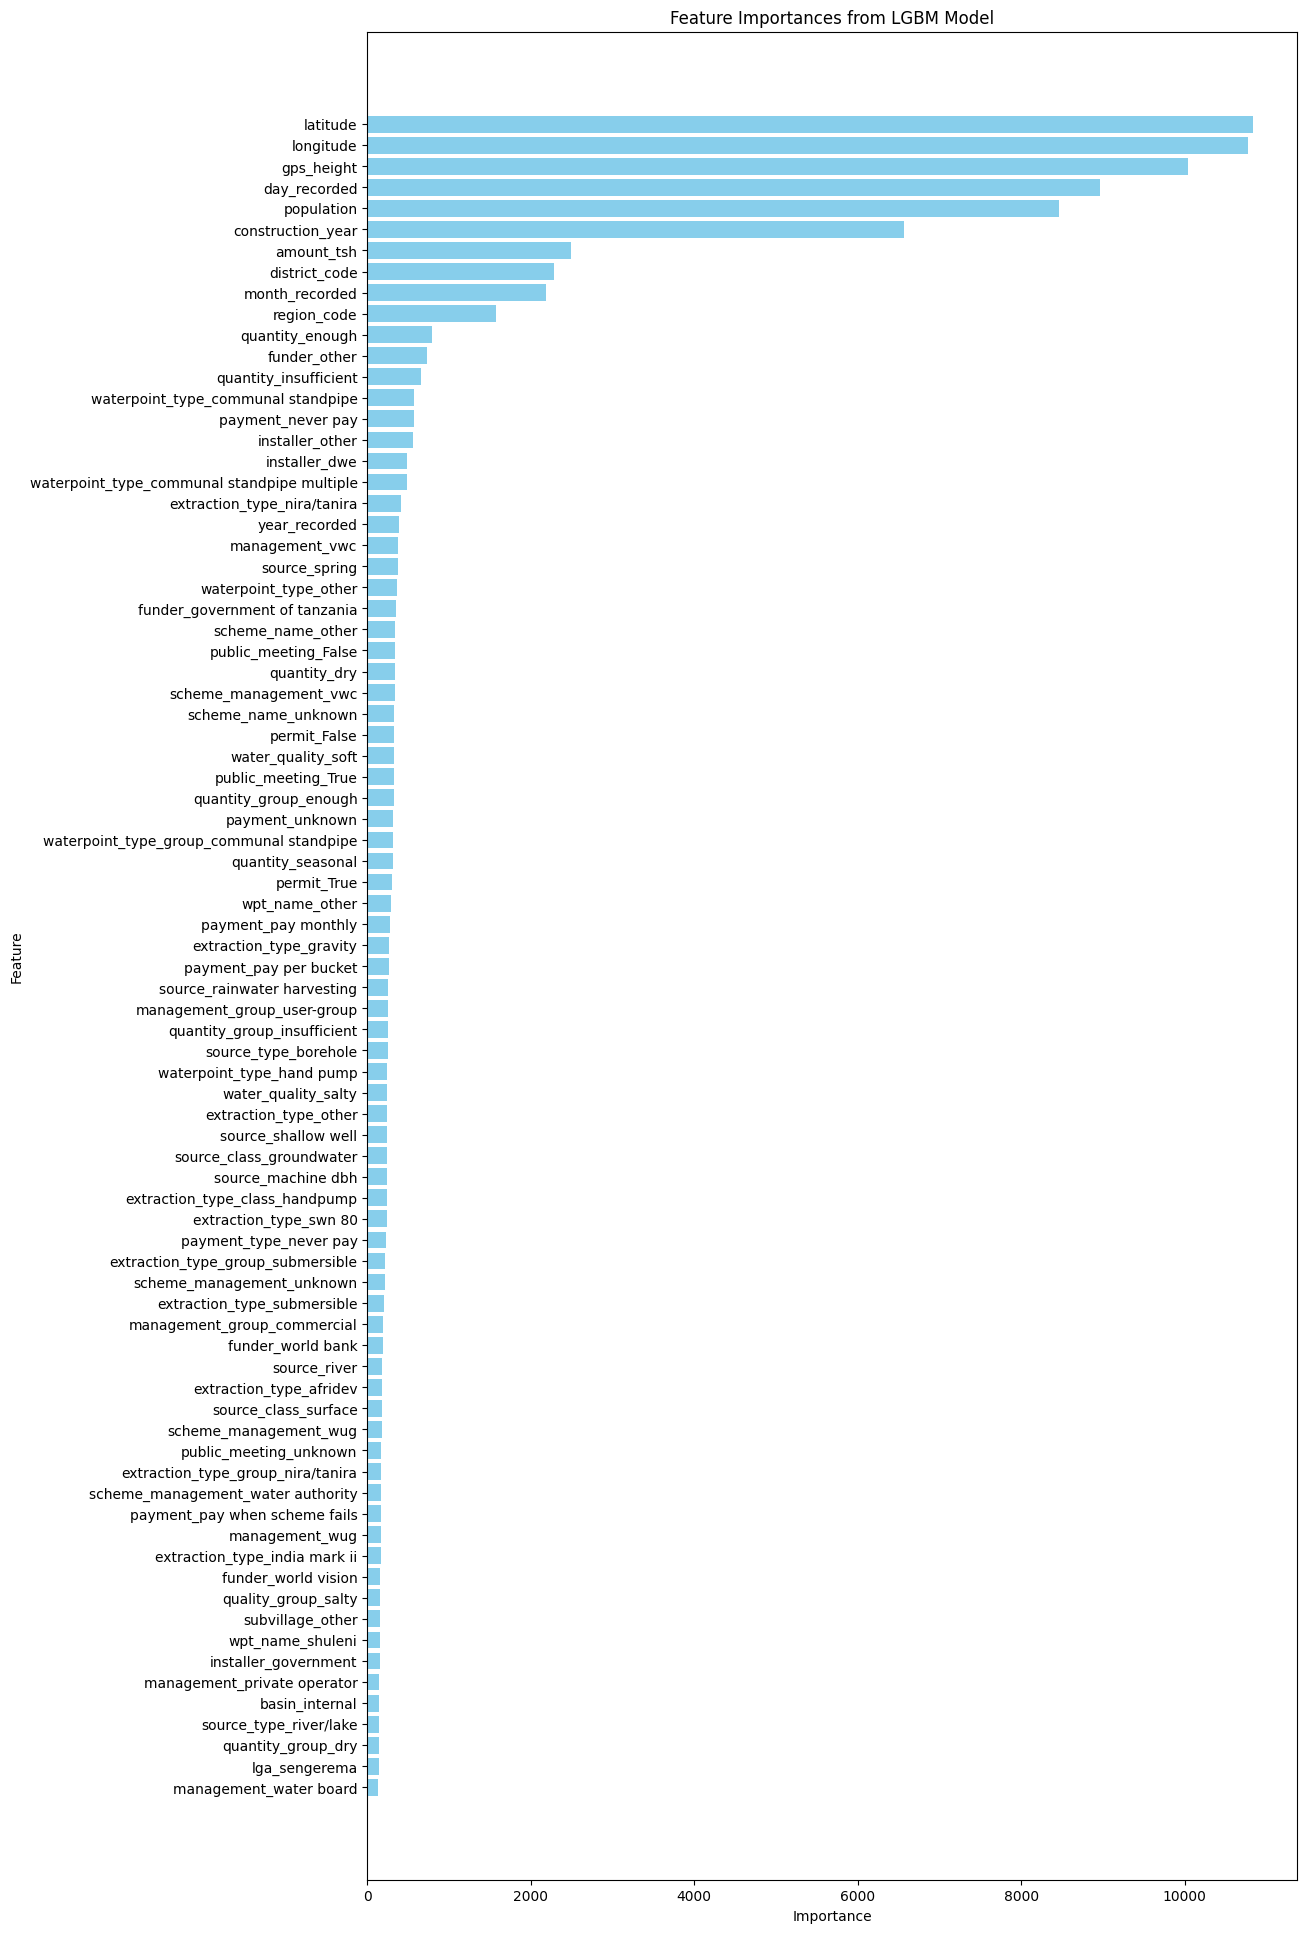

In [23]:
# Get feature importances from the best RandomForest model
lgbm_feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
lgbm_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': lgbm_feature_importances
})

# Sort the DataFrame by importance
lgbm_features_df = lgbm_features_df.sort_values(by='Importance', ascending=False).head(80)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(lgbm_features_df['Feature'], lgbm_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LGBM Model')
plt.gca().invert_yaxis()
plt.show()

In [24]:
# Predict using LGBM model
lgbm_test_preds = lgbm_model.predict(test_features_final)

# Replace values in 'status_group' with lgbm_test_preds
submission['status_group'] = lgbm_test_preds

submission.to_csv('submission_lgbm7.csv', index=False)

In [ ]:
from google.colab import runtime
runtime.unassign()